In [1]:
import pandas as pd
import statsmodels.api as sm

# 1.) Import Data from FRED

In [3]:
data = pd.read_csv("TaylorRuleData.csv", index_col = 0)

In [17]:
data.index = pd.to_datetime(data.index)

In [19]:
data.dropna(inplace = True)
data.head

<bound method NDFrame.head of             FedFunds  Unemployment  HousingStarts  Inflation
1959-01-01      2.48           6.0         1657.0     29.010
1959-02-01      2.43           5.9         1667.0     29.000
1959-03-01      2.80           5.6         1620.0     28.970
1959-04-01      2.96           5.2         1590.0     28.980
1959-05-01      2.90           5.1         1498.0     29.040
...              ...           ...            ...        ...
2023-07-01      5.12           3.5         1451.0    304.348
2023-08-01      5.33           3.8         1305.0    306.269
2023-09-01      5.33           3.8         1356.0    307.481
2023-10-01      5.33           3.8         1359.0    307.619
2023-11-01      5.33           3.7         1560.0    307.917

[779 rows x 4 columns]>

# 2.) Do Not Randomize, split your data into Train, Test Holdout

In [20]:
split_1 = int(len(data) * .6)
split_2 = int(len(data) * .9)
data_in = data[:split_1]
data_out = data[split_1:split_2]
data_hold = data[split_2:]

In [21]:
X_in = data_in.iloc[:,1:]
y_in = data_in.iloc[:,0]
X_out = data_out.iloc[:,1:]
y_out = data_out.iloc[:,0]
X_hold = data_hold.iloc[:,1:]
y_hold = data_hold.iloc[:,0]

In [22]:
# Add Constants
X_in = sm.add_constant(X_in)
X_out = sm.add_constant(X_out)
X_hold = sm.add_constant(X_hold)

# 3.) Build a model that regresses FF~Unemp, HousingStarts, Inflation

In [15]:
model1 = sm.OLS(y_in, X_in).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FedFunds   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     14.83
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           3.09e-09
Time:                        14:54:02   Log-Likelihood:                -1202.0
No. Observations:                 467   AIC:                             2412.
Df Residuals:                     463   BIC:                             2429.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.4750      0.985      3.529      0.000       1.540       5.410
Unemployment      0.5307      0.106      5.009      0.000       0.323       0.739
HousingStarts    -0.0005      0.000     -1.046      0.296      -0.001       0.000
Inflation         0.0077      0.004      2.173      0.030       0.001       0.015
==============================================================================
Omnibus:                       77.750   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.849
Skew:                           1.039   Prob(JB):                     2.11e-27
Kurtosis:                       4.413   Cond. No.                     1.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 4.) Recreate the graph for your model

In [16]:
import matplotlib.pyplot as plt

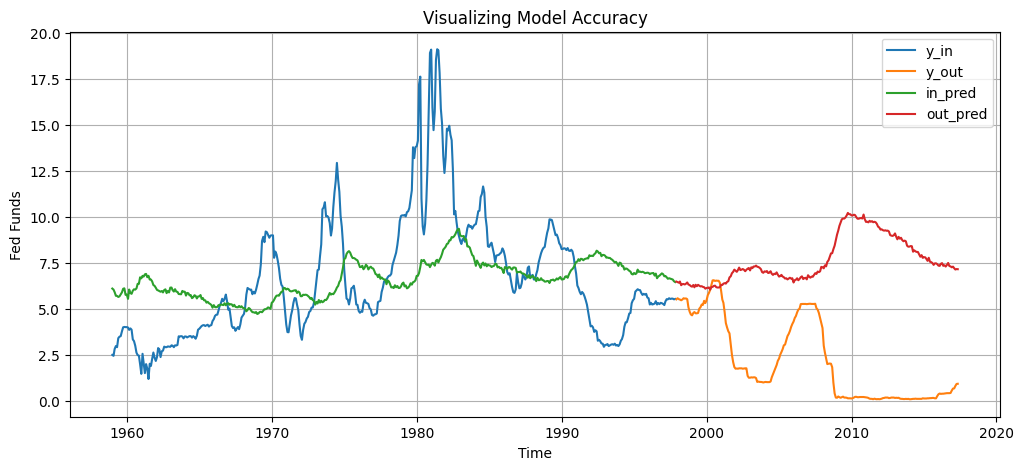

In [53]:
plt.figure(figsize = (12,5))

in_pred = model1.predict(X_in)
out_pred = model1.predict(X_out)

plt.plot(y_in) #Plot IS Actual
plt.plot(y_out) #Plot OOS Actual
plt.plot(in_pred) #Plot IS Predictions
plt.plot(out_pred) #Plot OOS Predictions

plt.ylabel("Fed Funds")
plt.xlabel("Time")
plt.title("Visualizing Model Accuracy")
plt.legend(["y_in", "y_out", "in_pred", "out_pred"])
plt.grid()
plt.show()

The model is probably underfitting - IS and OOS MSE are probably quite large. Therefore our assumption is probably wrong

## "All Models are wrong but some are useful" - 1976 George Box

# 5.) What are the in/out of sample MSEs

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
in_mse_1 = mean_squared_error(model1.predict(X_in), y_in)
out_mse_1 = mean_squared_error(model1.predict(X_out), y_out)

In [39]:
print("Insample MSE : ", in_mse_1)
print("Outsample MSE : ", out_mse_1)

Insample MSE :  10.071422013168641
Outsample MSE :  40.360827835668566


# 6.) Using a for loop. Repeat 3,4,5 for polynomial degrees 1,2,3

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [44]:
#Set Max Degrees
max_degrees = 3

Degree =  1


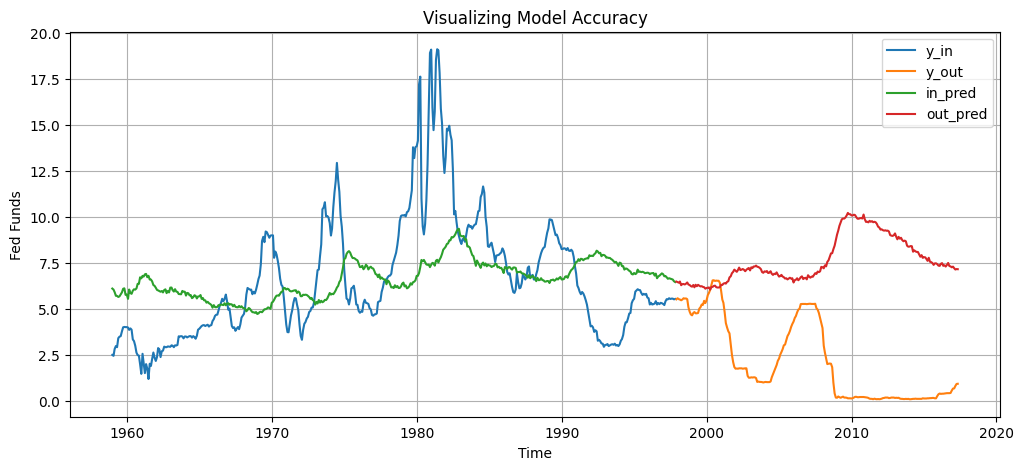

In-sample MSE :  10.071422013168641
Out-sample MSE :  40.36082783565212
Degree =  2


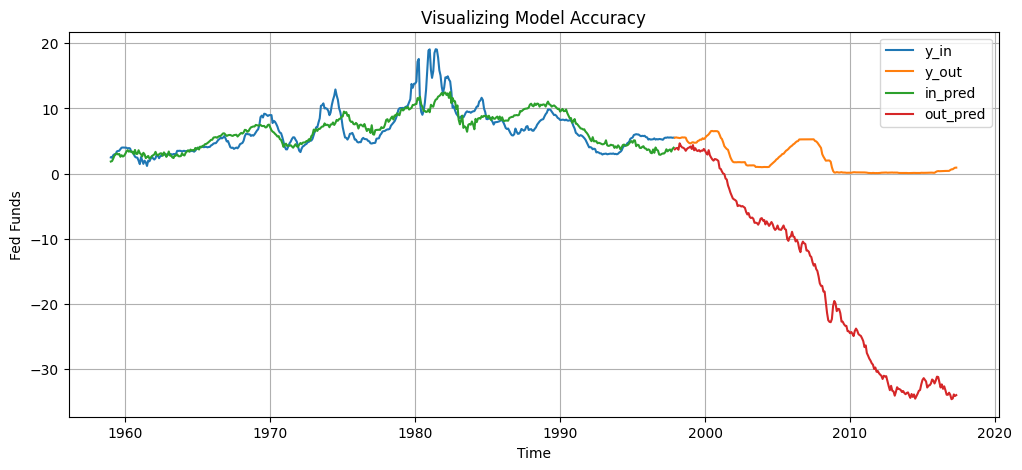

In-sample MSE :  3.863477139276067
Out-sample MSE :  481.4465099024015
Degree =  3


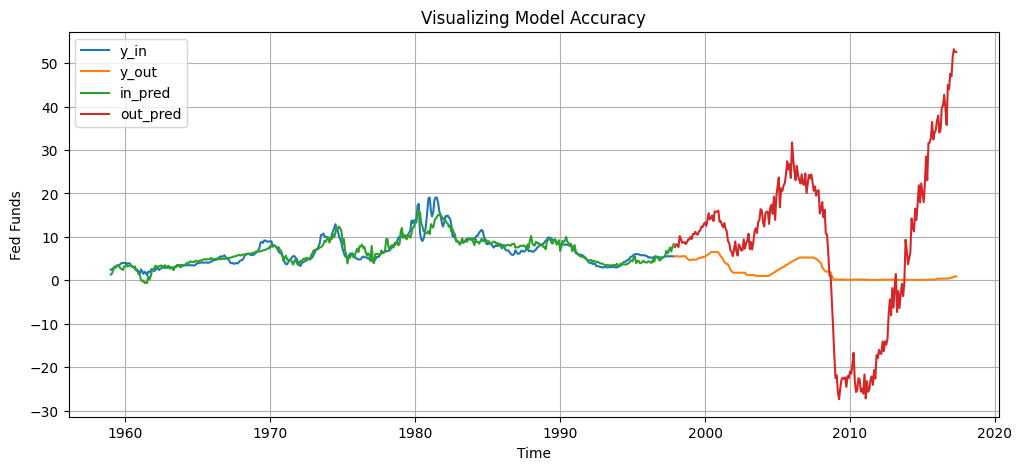

In-sample MSE :  1.872363628831326
Out-sample MSE :  371.7672613994206


In [57]:
for degrees in range(1, max_degrees+1):
    #set # of degrees
    print("Degree = ", degrees)
    poly = PolynomialFeatures(degree = degrees)
    X_in_poly = poly.fit_transform(X_in)
    X_out_poly = poly.transform(X_out)
    
    #Create model
    model = sm.OLS(y_in, X_in_poly).fit()

    #Create graph
    plt.figure(figsize = (12,5))
    #Update Predict indexes
    in_pred = model.predict(X_in_poly)
    in_pred = pd.DataFrame(in_pred, index = y_in.index)
    out_pred = model.predict(X_out_poly)
    out_pred = pd.DataFrame(out_pred, index = y_out.index)
    
    plt.plot(y_in) #Plot IS Actual
    plt.plot(y_out) #Plot OOS Actual
    plt.plot(in_pred) #Plot IS Predictions
    plt.plot(out_pred) #Plot OOS Predictions
    plt.ylabel("Fed Funds")
    plt.xlabel("Time")
    plt.title("Visualizing Model Accuracy")
    plt.legend(["y_in", "y_out", "in_pred", "out_pred"])
    plt.grid()
    plt.show()

    #Calculate MSE's
    in_mse_1 = mean_squared_error(model.predict(X_in_poly), y_in)
    out_mse_1 = mean_squared_error(model.predict(X_out_poly), y_out)

    print("In-sample MSE : ", in_mse_1)
    print("Out-sample MSE : ", out_mse_1)

# 7.) State your observations :

With a polynomial of degree 1, the in-sample MSE is higher than the models with polynomials of degrees 2 and 3 (which have MSE's of 3.86 and 1.87, respectively). We could therefore be tempted to say that the models utilizing the higher-order polynomials are better, however, we can see that in both of these cases, though we achieve a better fit with the in-sample portion of our data, the out-sample MSE drastically increases to 481.45 and 371.77, respectively, from only 40.36 with our model of degree 1.

Therefore, we can see that there's a tradeoff, since as we improve the fit of our in-sample portion much closer, we can see that the out-sample prediction gets much less accurate, exemplifying the bias-variance tradeoff.